{% from "macros.html" import figure %}

On 27 November 2022, the [Mauna Loa volcano in Hawai‘i started erupting](https://www.usgs.gov/volcanoes/mauna-loa/mauna-loa-2022-eruption) for the [first time since 1984](https://www.usgs.gov/volcanoes/mauna-loa/march-25-april-15-1984). The [eruption has now ceased](https://www.usgs.gov/volcanoes/mauna-loa/volcano-updates) and since its start the [Landsat 9 satellite](https://en.wikipedia.org/wiki/Landsat_9) has take two multi-spectral images (called *scenes*) of the volcano, one on 2 December and the other on 10 December. 

<figure>
<div class="ratio ratio-16x9">
<iframe scrolling="no" src="https://www.openstreetmap.org/export/embed.html?bbox=-156.05954445605472%2C19.328329860797416%2C-155.24379545800784%2C19.836946534206607&amp;layer=mapnik"></iframe>
</div>
<figcaption>
    
If you're unfamiliar with the Big Island of Hawai‘i, explore this interactive [OpenStreetMap](https://www.openstreetmap.org/copyright). The default view when it first loads should be roughly the same as the Landsat scenes we'll generate below.

</figcaption>
</figure>
    
In this article, we'll load and plot composites of these Landsat 9 scenes to try to get a glimpse of the eruption. The scenes were downloaded from [USGS EarthExplorer](https://earthexplorer.usgs.gov/) (WRS row/path = `063/046`) and I uploaded [selected bands as compressed archives to figshare](https://doi.org/10.6084/m9.figshare.21677246) (doi:[10.6084/m9.figshare.21677246](https://doi.org/10.6084/m9.figshare.21677246)) for archival and easier retrieval using [Pooch](https://www.fatiando.org/pooch). 

<div class="callout callout-warning">

**<i class="fas fa-exclamation-circle"></i> Important:** For official information on the eruption, please refer to the 
[USGS Hawaiian Volcano Observatory](https://www.usgs.gov/observatories/hvo) website.
This exploration is only meant as an exercise in data analysis and not as official
advice regarding the eruption.

</div>

Let's get started!

## Import libraries

We'll use the following libraries to manipulate the data and make some nice figures:

* [matplotlib](https://matplotlib.org/): the most popular Python plotting library (for a good reason, it's awesome).
* [matplotlib-scalebar](https://pypi.org/project/matplotlib-scalebar/): to add a scale bar to matplotlib figures (a good map always has a scale).
* [xlandsat](https://www.compgeolab.org/xlandsat/): a library developed by us at the [CompGeoLab](https://www.compgeolab.org/) for loading the Landsat scenes into [xarray](https://xarray.dev/) and making composites.
* [pooch](https://www.fatiando.org/pooch): for downloading data from a variety of sources, including figshare DOIs.

In [1]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import xlandsat as xls
import pooch

## Download the archived data

First, we'll use [Pooch](https://www.fatiando.org/pooch) to download the compressed archives with the scenes. The MD5 checksums were copied from the [figshare upload](https://doi.org/10.6084/m9.figshare.21677246) and are used by Pooch to verify if the download was successful. Both archives are around 500 Mb in size so this can take a little while depending on your internet connection.

In [2]:
doi = "10.6084/m9.figshare.21677246.v2"
paths = {}
paths["2022-12-02"] = pooch.retrieve(
    f"doi:{doi}/LC09_L2SP_063046_20221202_20221204_02_T1.tar.gz",
    known_hash="md5:3b2cb5dc4dbd4fbfad595124e9a59152",
    progressbar=True,
)
paths["2022-12-10"] = pooch.retrieve(
    f"doi:{doi}/LC08_L2SP_063046_20221210_20221219_02_T1.tar.gz",
    known_hash="md5:9dbff9fbc8ba6dc97c26b9133ab1544a",
    progressbar=True,
)

## Load the scenes

Next, we'll use [xlandsat](https://www.compgeolab.org/xlandsat/) to load a section of the scenes into `xarray.Dataset` objects. A nice feature of `xlandsat` is that it can load the data directly from the compressed archive without having to unpack it first.

We'll use the same region definition (in UTM coordinates) to make sure both scenes refer to exactly the same bounding box. This also helps keep the scenes a bit smaller in memory. The region was chosen to include the main volcanoes on the island and show some of the coastline for reference (particularly around the Kailua-Kona region).

In [5]:
region = [178500, 265000, 2140000, 2195000]  # UTM West, East, South, North
scenes = {
    date: xls.load_scene(paths[date], region=region) 
    for date in paths
}

One of the nice things about `xlandsat` is that it will include a lot of the metadata from the scenes in the `xarray.Dataset` and set the proper UTM coordinates for each pixel. This allows `xarray` to automate a lot of the boring parts of creating figures (setting axis labels, etc).

## RGB composites

Let's make some RGB (AKA "true color") composites to get an idea of what's going on. These will be heavily affected by the clouds and [vog](https://www.usgs.gov/faqs/what-vog-how-it-related-sulfur-dioxide-so2-emissions) but are good for visual inspection and getting our bearings. 

Generating composites with `xlandsat` is easy and by default it will use the red, green, and blue bands of the scene. We can also apply some re-scaling of the reflectance of each band to increase the contrast and avoid having the clouds and human structures saturate the image.

In [6]:
rgb = {
    date: xls.composite(scenes[date], rescale_to=[0, 0.2])
    for date in scenes
}

The composite is an `xarray.DataArray` that includes the right coordinates and metadata. Plotting it is as easy as calling `rgb["2022-12-02"].plot.imshow()`. We'll use a bit more code here to plot both scenes in the same figure and tweak some of the plot elements, in particular making the pixels squared by setting `ax.set_aspect("equal")`. 

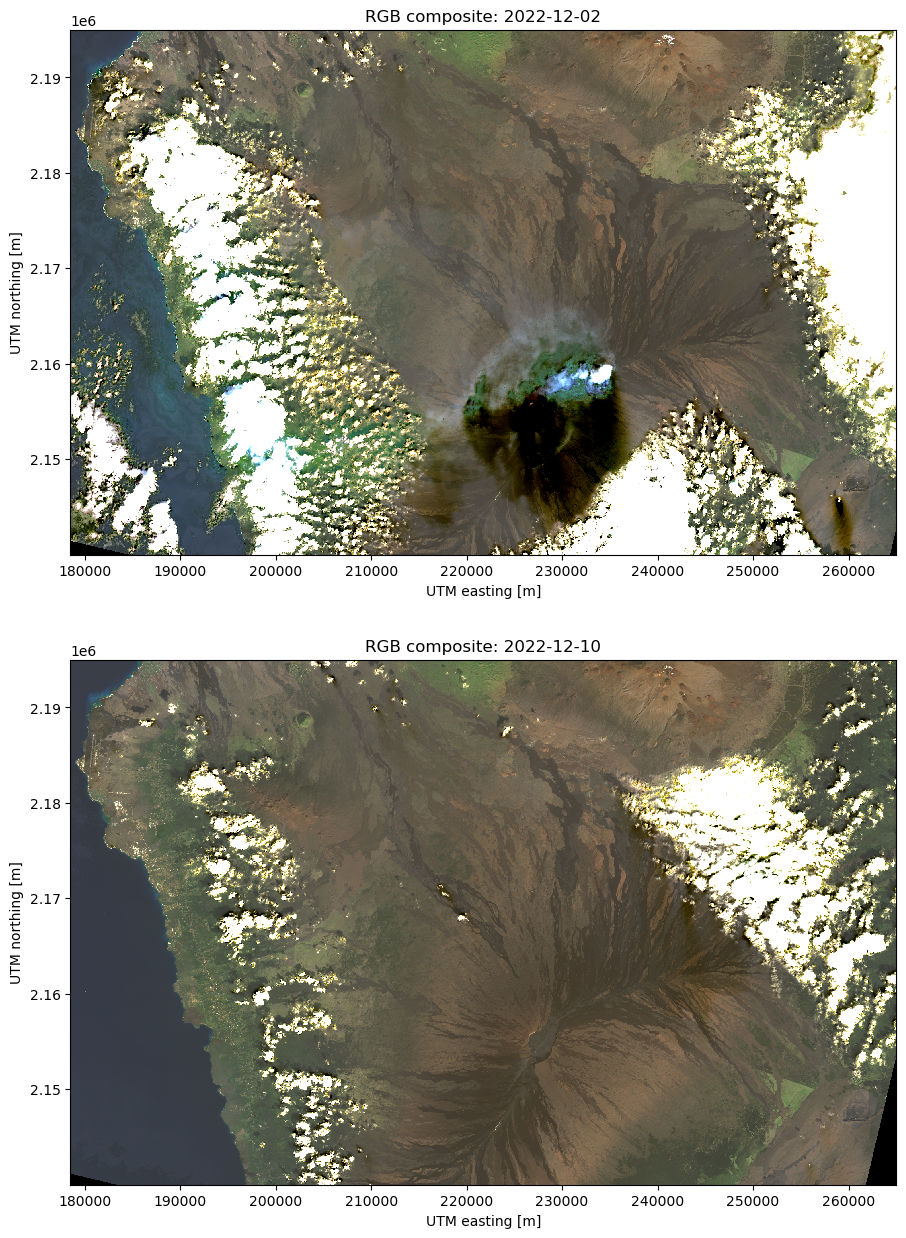

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(12, 15))
for date, ax in zip(sorted(scenes.keys()), axes):
    rgb[date].plot.imshow(ax=ax)
    ax.set_aspect("equal")
    ax.set_title(f"RGB composite: {date}")
    ax.set_facecolor("black")
plt.show()

Can't really see much because of the vog and the lava flows are dark so it's hard to distinguish between old and new flows. The infrared range has a higher chance of showing something since it's more sensitive to heat sources (like a fresh lava flow), particularly the short-wave infrared (SWIR) bands. 

## Infrared composites

We'll make a composite using the SWIR and near-infrared (NIR) bands to try to highlight the active lava flow and bypass the vog. It can look a bit unnatural but it offers a good glimpse of what's currently active. In this composite, the red colors represent the SWIR2 band, green is SWIR1, and blue is NIR.

In [7]:
infrared = {
    date: xls.composite(
        scenes[date], 
        bands=("swir2", "swir1", "nir"), 
        rescale_to=[0, 0.35],
    ) 
    for date in scenes
}

Now we can make some nicer figures, with a scale bar, caption at the bottom, and highlighting the [4 active volcanoes on the island](https://www.usgs.gov/observatories/hvo/active-volcanoes-hawaii). This time, we'll place each scene on their own figure so we can save them separately.

In [8]:
# Location to place the text for each volcano
volcanoes = {
    "Mauna Loa": (224000, 2148000),
    "Kīlauea": (259000, 2144000),
    "Mauna Kea": (230000, 2192000), 
    "Hualālai": (203000, 2178500),     
}
for date in scenes:
    fig, ax = plt.subplots(1, 1, figsize=(12, 10), facecolor="black")
    infrared[date].plot.imshow(ax=ax, interpolation="none")
    ax.set_aspect("equal")
    # Remove so that it looks fancier
    ax.axis("off")
    # Add a caption at the bottom
    text = (
        "Eruption of Mauna Loa, Hawai'i. "
        f"{scenes[date].attrs['title']}. "
        "Infrared composite: SWIR2, SWIR1, NIR. "
        "Created by Leonardo Uieda (CC0)."
    )
    ax.text(
        0.0075, 0.016, 
        text, 
        transform=ax.transAxes,
        color="white",
        fontsize=9,
        bbox=dict(
            facecolor="#000000dd",
            boxstyle="square",
            pad=0.75,
        ),
    )
    # Add text around each of the volcanoes
    for name in volcanoes:
        ax.text(
            *volcanoes[name], 
            name, 
            color="#dddddd",
            fontweight="bold",
            fontsize=10,
            ha="left",
        )
    # Add a scale bar
    ax.add_artist(
        ScaleBar(
            dx=1, 
            units="m", 
            location="upper left", 
            box_alpha=0,
            color="white", 
            scale_loc="bottom", 
            width_fraction=0.005, 
            length_fraction=0.06,
            pad=0.4,
        )
    )
    fig.tight_layout(pad=0)
    # Save the figures to JPG files with 2 resolutions
    for suffix, dpi in zip(["", "-low-res"], [600, 200]):
        plt.savefig(
            f"mauna-loa-landsat-{date}{suffix}.jpg", 
            bbox_inches="tight", 
            pad_inches=0, 
            dpi=dpi,
        )
    # Prevent the figures from being displayed so we can
    # insert them later and talk about each one separately
    plt.close()

Finally, here are the two scenes viewed as infrared composites. Remember that the SWIR bands are sensitive to heat sources and the NIR band tends to reflect very strongly on areas with vegetation cover (making them appear blue in these images). Old lava flows should appear as dark gray and black since they reflect poorly on most bands.


{{ figure("../images/mauna-loa-landsat-2022-12-02-low-res.jpg", 'Scene from 2022/12/02. The volcano can be seen surrounded by clouds and with the current lava flows showing up as a bright red and green North-South line in the middle of the image. The main crater also appears as slight red. We can even pick up something in the Hale Ma\'uma\'u crater of Kīlauea down in the Southeast.') }}

The lava flow is heading to the North, where it nearly reached the Daniel K. Inouye Highway which connects both sides of the island. If you zoom in on the higher resolution version of the image you can even see the road near the slope of Mauna Kea. 

{{ figure("../images/mauna-loa-landsat-2022-12-10-low-res.jpg", 'Scene from 2022/12/10. The volcano is still surrounded by clouds and with the current lava flows showing up as a thin strip of light red and green. The main crater is no longer slight red and the northern tip of the lava flow is covered in clouds and therefore hard to make out.') }}

From the 10 December scene we can see that the activity seems to have almost disappeared, except for some slight signal in the SWIR bands still visible in the main flow channel. The [USGS Hawaiian Volcano Observatory](https://www.usgs.gov/observatories/hvo) has issued a [statement that the eruption has ended as of 15 December 2022](https://www.usgs.gov/volcanoes/mauna-loa/volcano-updates) so this is likely the last Landsat scene that will show much of this eruption.

<div class="callout callout-note">

**<i class="fas fa-images"></i> Want to download these images?** High and low resolution versions of both of them are [available on figshare](https://doi.org/10.6084/m9.figshare.21677246) (doi:[10.6084/m9.figshare.21677246](https://doi.org/10.6084/m9.figshare.21677246)) under a [CC0 license](https://creativecommons.org/publicdomain/zero/1.0/).
    
</div>

## What now?

So it seems that the eruption has fully stopped and new Landsat scenes that would become available later in December 2022 will very likely not show anything remarkable (besides the already stunning views of Hawai‘i). If anything does come up, I may update this notebook.

If you're still curious and want to play with some more data, you can download scenes from the [USGS EarthExplorer](https://earthexplorer.usgs.gov/) with a free account and easily load them with [xlandsat](https://www.compgeolab.org/xlandsat/) just as I did above. A while back, I even made a [YouTube video on how to select and download scenes from EarthExplorer](https://www.youtube.com/watch?v=Wn_G4fvitV8), so go watch that if you want to get started right away.

[![Screenshot from the YouTub video on how to download Landsat scenes from EarthExplorer showing my at the bottom right corner and the website with a download window open.](../images/screenshot-downloading-landsat-images.jpg)](https://www.youtube.com/watch?v=Wn_G4fvitV8)

**I hope this was a fun and useful learning experience. It sure was for me!**

<div class="callout mt-5">

**Licenses and original sources:**
    
This blog post was originally written as a Jupyter notebook which can be found at the [<i class="fab fa-github"></i> `compgeolab/mauna-loa-landsat-2022` GitHub repository](https://github.com/compgeolab/mauna-loa-landsat-2022). Comments, corrections, and additions are welcome.

All Python source code is made available under the [MIT license](https://github.com/compgeolab/mauna-loa-landsat-2022/blob/main/LICENSE). 
You can freely use and modify the code, without warranty, so long as you provide attribution to the authors. All text and figures in this post are available under the [Creative Commons Public Domain Dedication (CC0)](https://creativecommons.org/publicdomain/zero/1.0/).
    
</div>